# Modelling and Evaluation Notebook

## Objectives
* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
    * Image shape embeddings

## Outputs 
    * Images distribution plot in train, validation and test set
    * Image augmentation
    * Class indices to change prediction inference in labels
    * Machine learning model creation and training
    * Save model
    * Learning curve plot for model performance
    * Model evaluation on pickle file
    * Prediction on the random image file
    
## Additional Comments | Insights | Conclusions

# Set Data Directory

## Import Libraries

In [37]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [ ]:
current_dir = os.getcwd()
current_dir

In [ ]:
os.chdir('/workspace/NEW-CHERRY-LEAVES')
print("You set a new current directory")

In [ ]:
work_dir = os.getcwd()
work_dir

## Set Input Directories
Set train, validation and test paths

In [41]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [ ]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

### Set labels

In [ ]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

## Set image shape

In [ ]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

---

## Number of images in train, test and validation data

In [ ]:
df_freq = pd.DataFrame([]) 
data = []  # Collect data in a list instead of appending directly

for folder in ['train', 'validation', 'test']:
    for label in labels:
        frequency = int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        data.append({'Set': folder, 'Label': label, 'Frequency': frequency})
        
        print(f"* {folder} - {label}: {frequency} images")

# Convert the collected data into a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image data augmentation

---

### ImageDataGenerator

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [47]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Augment training image dataset

In [ ]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

### Augment validation image dataset

In [ ]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

### Augment test image dataset

In [ ]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

## Plot augmented training image

In [ ]:
! pip install scipy

In [ ]:
for _ in range(3):
    img, label = train_set.__next__()  # Directly calling the iterator method
    print(img.shape)  # Expected output: (1, 256, 256, 3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

In [ ]:
for _ in range(3):
    img, label = validation_set.__next__() 
    print(img.shape)  # Expected output: (batch_size, 256, 256, 3)

    plt.imshow(img[0])
    plt.axis('off')
    plt.show()


In [ ]:
for _ in range(3):
    img, label = test_set.__next__()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [ ]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

---

## Model creation

### ML Model

* #### Import model packages

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* #### Model

In [57]:
def create_tf_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

* #### Model Summary

In [ ]:
create_tf_model().summary()

* #### Early Stopping

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

### Fit model for model training

In [66]:
import math

steps_per_epoch = math.ceil(train_set.samples / batch_size)

model = create_tf_model()
model.fit(
    train_set,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_set,
    callbacks=[early_stop],
    verbose=1
)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 135s 905ms/step - accuracy: 0.7731 - loss: 0.4632 - val_accuracy: 0.8500 - val_loss: 0.5610
Epoch 2/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 132s 888ms/step - accuracy: 0.9626 - loss: 0.1174 - val_accuracy: 0.9857 - val_loss: 0.0302
Epoch 3/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 132s 894ms/step - accuracy: 0.9876 - loss: 0.0408 - val_accuracy: 0.9833 - val_loss: 0.0699
Epoch 4/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 132s 893ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9952 - val_loss: 0.0124
Epoch 5/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 133s 895ms/step - accuracy: 0.9913 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 6/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 131s 883ms/step - accuracy: 0.9787 - loss: 0.0785 - val_accuracy: 0.9881 - val_loss: 0.0358
Epoch 7/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 132s 895ms/step - accuracy: 0.9883 - loss: 0.0340 - val_accuracy: 0.9976 - val_loss: 0.0081
Epoch 8/25
148/148 ━━━━━━━━━━━━━━━━━━━━ 131s 888ms/step - accuracy: 0.9944 -

### Save Model

In [67]:
model.save('outputs/v1/cherry_leaves_model.h5')

---

## Model Performance

### Model learning curve

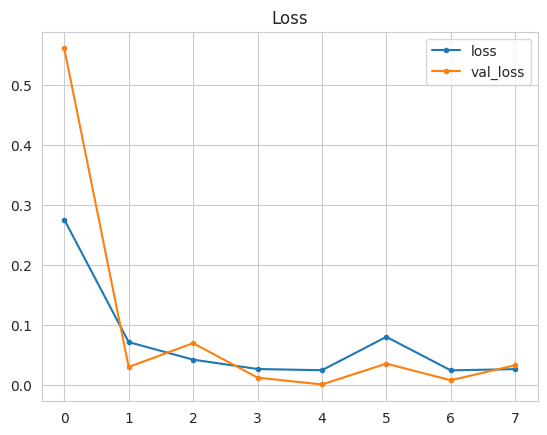

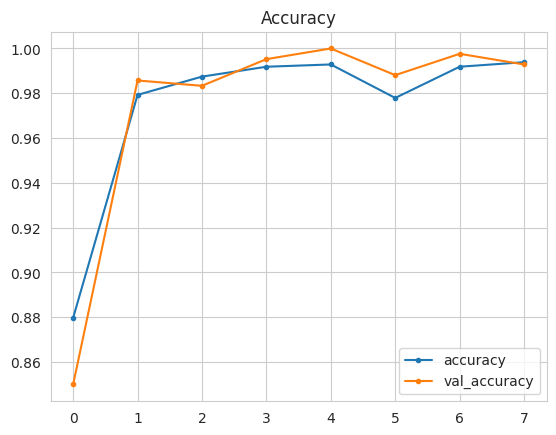

In [68]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Evaluate model on test set.

* The performance on the test set meets the project requirements (at least 97% accuracy on the test set)

Load saved model

In [69]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')

#### Evaluate model accuracy on the test set

In [70]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9991 - loss: 0.0040
Test Accuracy: 99.76%


### Save evaluation pickle

In [71]:
evaluation = model.evaluate(validation_set, verbose=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9989 - loss: 0.0043


In [72]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


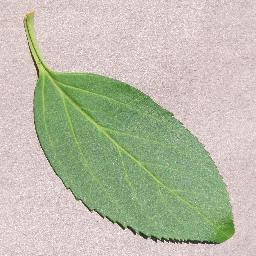

In [73]:
from tensorflow.keras.preprocessing import image
import random

label = random.choice(labels) 

pointer = random.randint(0, len(os.listdir(test_path + '/' + label)) - 1)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path + '/' + label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [74]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [75]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
0.9999911
healthy


---

## Push files to Repo
### Push generated/new files from this session to GitHub repo
* .gitignore

In [77]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [78]:
!git status

On branch main
Your branch is behind 'origin/main' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   README.md
	modified:   app_pages/page_cherryleaves_visualizer.py
	modified:   jupyter_notebooks/DataCollection.ipynb
	modified:   jupyter_notebooks/DataVisualization.ipynb
	modified:   jupyter_notebooks/ModellingandEvaluating.ipynb
	deleted:    jupyter_notebooks/Notebook_Template.ipynb
	modified:   outputs/v1/avg_diff.png
	modified:   outputs/v1/avg_var_healthy.png
	modified:   outputs/v1/avg_var_powdery_mildew.png
	modified:   outputs/v1/cherry_leaves_model.h5
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

Untracked files:
  (use "git add <file>..." to include in what will be committ

* Git add 

In [3]:
!git add .

* Git commit

In [ ]:
!git commit -am " Modify streamlit pages"

* Git Push

In [ ]:
!git push

---